<a href="https://colab.research.google.com/github/Kalebe-Nascimento/Transfer-Learning/blob/main/Kalebe_Tranf_Learning_Flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neste projeto iremos baixar uma bibliotecas e usando o aprendizado de transferência de uma rede pré-treinada para defir o tipo de flor.

Um modelo pré-treinado é uma rede salva que foi previamente treinada em um grande conjunto de dados, normalmente em uma tarefa de classificação de imagem em grande escala. Você usa o modelo pré-treinado como está ou usa o aprendizado de transferência para personalizar esse modelo para uma determinada tarefa.

Adicionando as bibliotecas que serão usadas

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import glob
import cv2 as cv2
import random
from sklearn.model_selection import train_test_split


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

Baixando os arquivos onde estão as fotos da flores

In [3]:
_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
path_to_zip = tf.keras.utils.get_file('flower_photos.tgz', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'flower_photos')

228813984/228813984 [==============================] - 4s 0us/step


In [4]:
PATH

'/root/.keras/datasets/flower_photos'

In [5]:
os.listdir(PATH)


['sunflowers', 'roses', 'dandelion', 'daisy', 'LICENSE.txt', 'tulips']

Dividindo em cinco classes (flores) em caminhos únicos

In [6]:
daisy_dir = glob.glob (os.path.join(PATH,'daisy'))
dandelion_dir = glob.glob (os.path.join(PATH,'dandelion'))
roses_dir = glob.glob (os.path.join(PATH,'roses'))
sunflower_dir = glob.glob (os.path.join(PATH,'sunflower'))
tulips_dir = glob.glob (os.path.join(PATH,'tulips'))

In [7]:
all_dataset = tf.keras.utils.image_dataset_from_directory(PATH,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 3670 files belonging to 5 classes.


In [8]:
train_size = int(0.8 * len(all_dataset))
val_size = int(0.10 * len(all_dataset))
test_size = int(0.10 * len(all_dataset))


Mostre as primeiras nove imagens e rótulos do conjunto de treinamento:

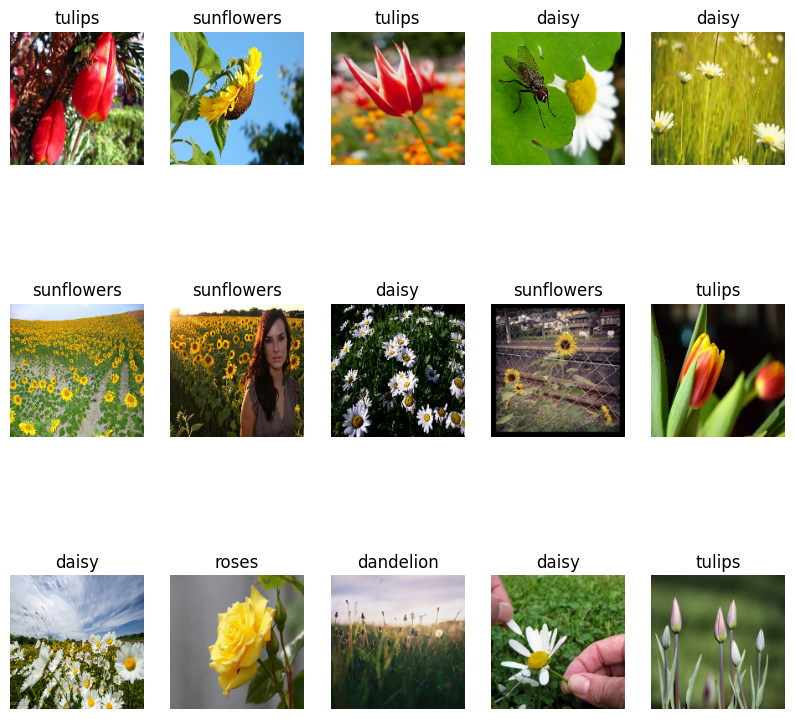

In [9]:
class_names = all_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in all_dataset.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
train_dataset = all_dataset.take(train_size)
validation_dataset = all_dataset.skip(train_size).take(val_size)
test_dataset = all_dataset.skip(train_size + val_size).take(test_size)

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 11


Configurando o conjuto para desempenho e aprendizado melhor dos dados

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

#Usando data_augmentation

Quando você não tem um grande conjunto de dados de imagem, é uma boa prática introduzir artificialmente a diversidade de amostra aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como rotação e inversão horizontal.

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

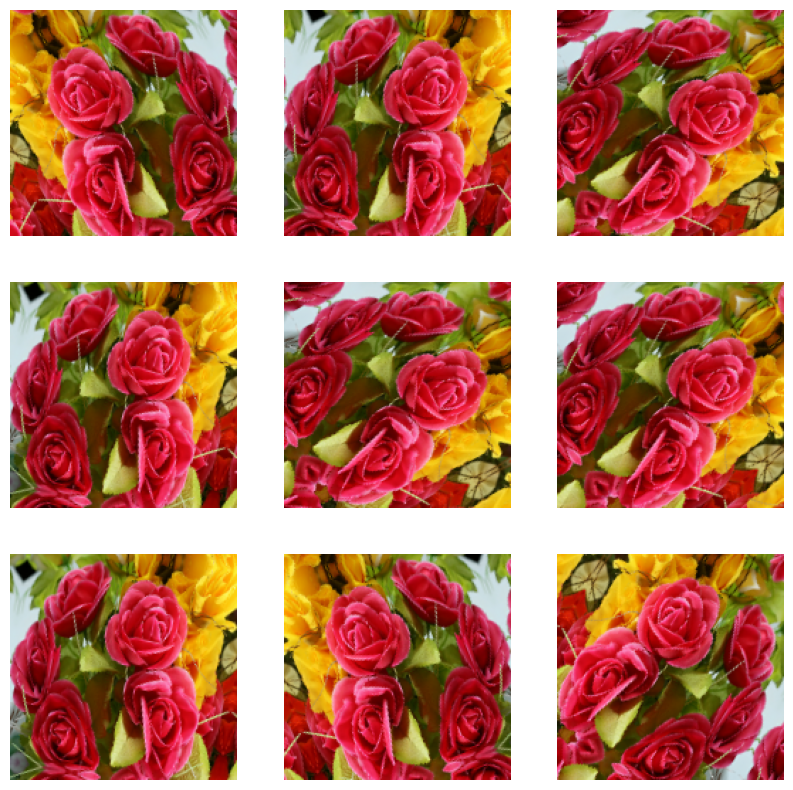

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Redimensionar valores de pixel

Em instantes, você fará o download do tf.keras.applications.MobileNetV2 para uso como modelo base. Este modelo espera valores de pixel em [-1, 1] , mas neste ponto, os valores de pixel em suas imagens estão em [0, 255] . Para redimensioná-los, use o método de pré-processamento incluído no modelo.

In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [17]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [18]:
IMG_SIZE

(160, 160)

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [21]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [22]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [23]:
base_model.trainable = False

# Adicionar um cabeçalho de classificação

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [25]:
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


### Compilar o modelo
Compile o modelo antes de treiná-lo. Como existem duas classes, use a perda `tf.keras.losses.BinaryCrossentropy` com `from_logits=True` , pois o modelo fornece uma saída linear.

In [26]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense((1280))(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [27]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Treinando o modelo
Após treinar por 10 épocas obterá um bom resultado


In [29]:
initial_epochs = 15

loss0, accuracy0 = model.evaluate(validation_dataset)

11/11 [==============================] - 14s 588ms/step - loss: 2.2156 - accuracy: 0.1477


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.22
initial accuracy: 0.15


In [31]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/15
92/92 [==============================] - 87s 902ms/step - loss: 0.7058 - accuracy: 0.7391 - val_loss: 0.3284 - val_accuracy: 0.9006
Epoch 2/15
92/92 [==============================] - 89s 967ms/step - loss: 0.3824 - accuracy: 0.8553 - val_loss: 0.3883 - val_accuracy: 0.8693
Epoch 3/15
92/92 [==============================] - 89s 961ms/step - loss: 0.3469 - accuracy: 0.8770 - val_loss: 0.2998 - val_accuracy: 0.9062
Epoch 4/15
92/92 [==============================] - 95s 1s/step - loss: 0.3133 - accuracy: 0.8849 - val_loss: 0.3518 - val_accuracy: 0.8949
Epoch 5/15
92/92 [==============================] - 89s 967ms/step - loss: 0.2907 - accuracy: 0.8967 - val_loss: 0.2744 - val_accuracy: 0.9176
Epoch 6/15
92/92 [==============================] - 90s 972ms/step - loss: 0.2835 - accuracy: 0.8944 - val_loss: 0.2608 - val_accuracy: 0.9034
Epoch 7/15
92/92 [==============================] - 87s 941ms/step - loss: 0.2605 - accuracy: 0.9079 - val_loss: 0.2345 - val_accuracy: 0.9233
Ep

# Curvas de aprendizado
Vamos dar uma olhada nas curvas de aprendizado da precisão/perda de treinamento e validação ao usar o modelo base MobileNetV2 como um extrator de recursos fixo.

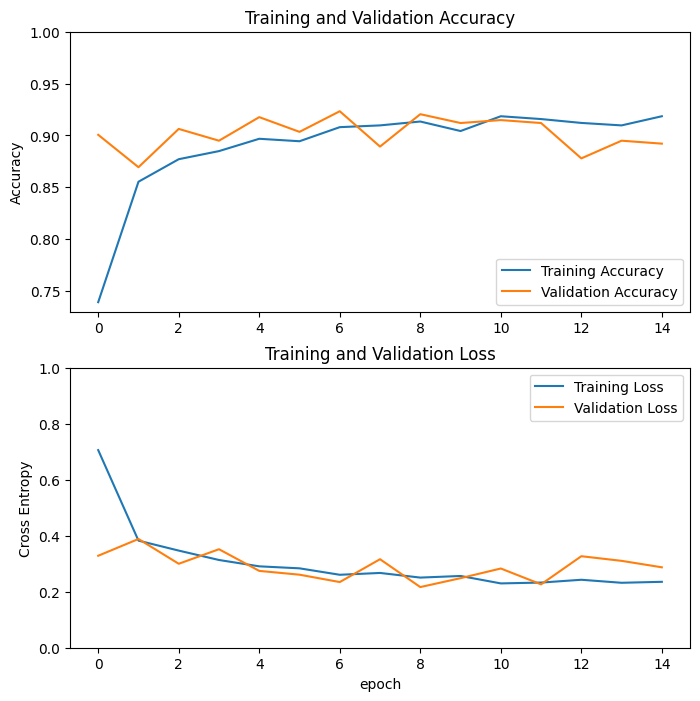

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Avaliação e previsão
Finalmente, você pode verificar o desempenho do modelo em novos dados usando o conjunto de teste.

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

11/11 [==============================] - 14s 724ms/step - loss: 0.3261 - accuracy: 0.8920
Test accuracy : 0.8920454382896423


Predictions:
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Labels:
 [2 3 3 1 0 3 3 3 3 2 3 1 1 1 2 1 1 1 0 1 2 4 3 4 3 2 0 4 3 2 3 4]


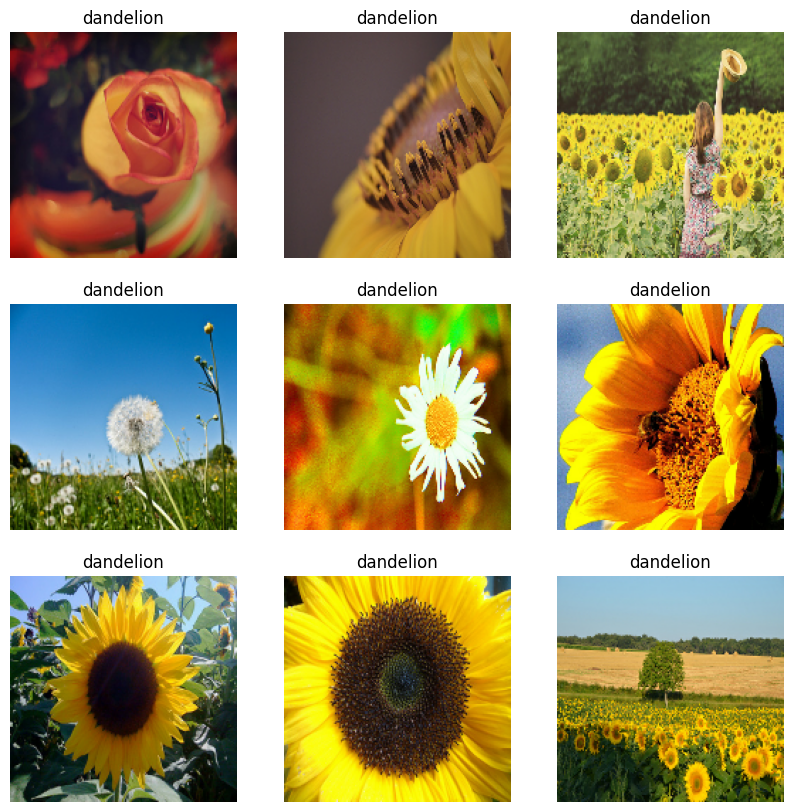

In [35]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")